In [1]:
# NOTEBOOK IS MEANT TO BE RUN ENTIRE WAY THROUGH AFTER EACH ITERATION
# AUTOLOCKING OF DATA HELPS TO PRESERVE MODEL OUTPUT THAT MAY HAVE BEEN OVERWRITTEN ON EACH MODEL RUN
# INDIVIDUAL PURPOSES CAN BE LOCKED AT ANY ROUND AND THEY WILL DROP OUT OF ADJUSTMENT AND SMOOTHING

# debug toggle to turn on display of dataframes in cell outputs
debug = False

import pandas as pd  
import os
import plotly as py
import plotly.graph_objects as go
import plotly.express as px
import ipywidgets as widgets
import numpy as np
from scipy import special
import time

# offline mode for charts, so it stays local
py.offline.init_notebook_mode(connected=True)

# set rounding precision and display precision - display is rounding + 1, so you can see that it's working
round_precision = 7
pd.set_option("display.precision", round_precision + 1)

# read in curve data'
dirCWD    = os.getcwd()
dirIntermediate = os.path.join(dirCWD,'_Friction_Factors')
dirResults = os.path.join(dirCWD,'_Friction_Factors')

binsize = 2

observedStage = 'v9 Final Smoothing'

filenameTLFObs  = r'A:\1 - TDM\2 - Estimate Param\_General Parameters\7 - Update Obs TLF\3 - Create Obs TLFs for all Trips\results\dfTLF_Obs_wSmoothed_20221209-075253.csv'
folderTDMTLFLoc = r'A:\1 - TDM\3 - Model Dev\1 - WF\2 - Sandbox\v9.0Beta\WF TDM v9.0 - 2022-11-01\Scenarios\BY_2019\3_Distribute\TLF'
folderFFLoc     = r'A:\1 - TDM\3 - Model Dev\1 - WF\2 - Sandbox\v9.0Beta\WF TDM v9.0 - 2022-11-01\1_Inputs\0_GlobalData\3_Distribute'

# some trip purposes are added together for information purposes
dfTripPurpSubtotals = pd.DataFrame([
    ['HBOth','HBO' ],
    ['HBShp','HBO' ],
    ['NHBW' ,'NHB' ],
    ['NHBNW','NHB' ],
    ['IX'   ,'IXXI'],
    ['XI'   ,'IXXI']
],columns=(['TRIPPURP','TRIPPURP_SUB']))
if debug: display(dfTripPurpSubtotals)

# calibration round settings
dfCalibrationRounds = pd.DataFrame([
    ['0','0-Initial Take 2'     ],
    ['1','1-First Charm'        ],
    ['2','2-Burning the Oil'    ],
    ['3','3-Rise and Shout'     ],
    ['4','4-Dim the Lights'     ],
    ['5','5-Please no More'     ],
    ['6','6-Bring it On'        ],
    ['7','7-Night of the Model' ],
    ['8','8-Mind Your Ps and As'],
    ['9','9-Same as 8'          ]
],columns=(['INDEX_NUM','FF_CALIB_ROUND']))

# create and initialize locking fields
dfCalibrationRounds['LOCKFF' ] = False
dfCalibrationRounds['LOCKTLF'] = False

# AUTOLOCK ALL BUT LAST CALIBROUND TO AVOID OVERWRITING DATA IF NOT MANUALLY LOCKED
dfCalibrationRounds.loc[(dfCalibrationRounds.index<dfCalibrationRounds.shape[0]-1), 'LOCKFF' ] = True
dfCalibrationRounds.loc[(dfCalibrationRounds.index<dfCalibrationRounds.shape[0]-1), 'LOCKTLF'] = True

display(dfCalibrationRounds)

# a set of column renaming to be used to put all columns in consistent naming
colRenames ={'HBOTH':'HBOth',
             'HBSHP':'HBShp',
             'HBSCHPR' :'HBSchPr',
             'HBSCHSC' :'HBSchSc',
             'HBSCH_PR':'HBSchPr',
             'HBSCH_SC':'HBSchSc',
             'HBSch_Pr':'HBSchPr',
             'HBSch_Sc':'HBSchSc'}

# max bin for normalizing adjusted FF (setting max=1)... in bins higher than this value, any value greater than 1.0 will be set to 1.0
nrmlz_max_bin = 100

# use entire width of browser for cells
#from IPython.display import display, HTML
#display(HTML("<style>.container { width:100% !important; }</style>"))

,INDEX_NUM,FF_CALIB_ROUND,LOCKFF,LOCKTLF
0,0,0-Initial Take 2,True,True
1,1,1-First Charm,True,True
2,2,2-Burning the Oil,True,True
3,3,3-Rise and Shout,True,True
4,4,4-Dim the Lights,True,True
5,5,5-Please no More,True,True
6,6,6-Bring it On,True,True
7,7,7-Night of the Model,True,True
8,8,8-Mind Your Ps and As,True,True
9,9,9-Same as 8,False,False


In [2]:
# create intermediate directories for each round
for index, row in dfCalibrationRounds.iterrows():
    path_ffcb = os.path.join(dirIntermediate,str(index))

    # Check whether the specified path exists or not
    isExist = os.path.exists(path_ffcb)
    if not isExist:
        os.makedirs(path_ffcb)
        print("The new directory is created! " + path_ffcb)

    path_ms = os.path.join(path_ffcb,'manual_smoothing')

    # Check whether the specified path exists or not
    isExist = os.path.exists(path_ms)
    if not isExist:
        os.makedirs(path_ms)
        print("The new directory is created! " + path_ms)

    path_fnr = os.path.join(path_ffcb,'factors for next round')
    isExist = os.path.exists(path_fnr)
    
    #printing if the path exists or not
    if not isExist:
        os.makedirs(path_fnr)
        print("The new directory is created! " + path_fnr)


# Observed Trip Length Frequencies

In [30]:
# read in observed TLF data to be used
dfTLF_Obs = pd.read_csv(filenameTLFObs)

#filter by the STAGE for 
#dfTLF_Obs = dfTLF_Obs[dfTLF_Obs['STAGE']==observedStage].copy()
#dfTLF_Obs = dfTLF_Obs.drop(columns=('STAGE'))
if debug: display(dfTLF_Obs)

In [31]:
# show max bin size for TLF type to use in updating TDM TLF code
if debug: display(dfTLF_Obs[dfTLF_Obs['FREQ']>0].groupby(['TLFTYPE'],as_index=False).agg(MAXBIN=('BIN','max')))

In [32]:
# Check TLF Observed. FREQ should all sum to 1! Also show average trip length
# add one to BIN to get bin midpoint
dfTLF_Obs['BINMIDxFREQ'] = (dfTLF_Obs['BIN'] + 1) * dfTLF_Obs['FREQ']
dfTLF_Obs_Stats = dfTLF_Obs.groupby(['STAGE','TRIPPURP','TLFTYPE'],as_index=False).agg(FREQ_SUM=('FREQ','sum'),AVG_TRIP_LEN=('BINMIDxFREQ','sum'))
dfTLF_Obs.drop(columns=('BINMIDxFREQ'), inplace=True)
if debug: display(dfTLF_Obs_Stats)
display(dfTLF_Obs_Stats)

,STAGE,TRIPPURP,TLFTYPE,FREQ_SUM,AVG_TRIP_LEN
0,v832 Final Smoothing,All Trips,Dist,1.0,6.38814514
1,v832 Final Smoothing,All Trips,GC,1.0,21.44858256
2,v832 Final Smoothing,All Trips,Time,1.0,13.82494714
3,v832 Final Smoothing,HBOth,Dist,1.0,4.63263940
4,v832 Final Smoothing,HBOth,GC,1.0,17.17713600
...,...,...,...,...,...
205,v9 Unsmoothed,XI_HV,GC,1.0,158.78179379
206,v9 Unsmoothed,XI_HV,Time,1.0,73.50584930
207,v9 Unsmoothed,XI_MD,Dist,1.0,43.12571315
208,v9 Unsmoothed,XI_MD,GC,1.0,100.30330370


# Friction Factors

In [33]:
# read Friction Factors into array ordered by iteration

# Friction Factors array that stores a separate dataframe for each Calibration Round
dfsFF=[]

for index, row in dfCalibrationRounds.iterrows():
    filename = os.path.join(os.path.join(dirIntermediate,str(index)),'1-friction factors begin.csv')
    if row['LOCKFF']==False:
        display ('Reading friction factors for ' + row['FF_CALIB_ROUND'])

        read_ff_filename = os.path.join(folderFFLoc,'FricFactor_AllPurp_r' + row['INDEX_NUM'] + '.csv')
        dfFF = pd.read_csv(read_ff_filename)

        # make sure id column is always same: BIN
        dfFF.rename(columns={';BIN':'BIN',';MINUTE':'BIN','Mile':'BIN','Mil':'BIN','Min':'BIN','Bin':'BIN'},inplace=True)
        # rename columns
        dfFF.rename(columns=colRenames,inplace=True)

        if debug: display(dfFF)

        # melt all columns but first
        dfFF = pd.melt(dfFF, id_vars=['BIN'], value_vars=dfFF.columns[1:].tolist(), ignore_index=False, var_name='TRIPPURP', value_name='FF')

        dfFF.to_csv(filename, index=False)

    else:
        display ('Reading csv for ' + row['FF_CALIB_ROUND'])
        dfFF = pd.read_csv(filename)

    # append to array of Friction Factors
    dfsFF.append(dfFF)

    if debug: display(dfFF)


'Reading csv for 0-Initial Take 2'

'Reading csv for 1-First Charm'

'Reading csv for 2-Burning the Oil'

'Reading csv for 3-Rise and Shout'

'Reading csv for 4-Dim the Lights'

'Reading csv for 5-Please no More'

'Reading csv for 6-Bring it On'

'Reading csv for 7-Night of the Model'

'Reading csv for 8-Mind Your Ps and As'

'Reading friction factors for 9-Same as 8'

# Read in TDM Trip Length Frequencies

In [34]:
# read in trips from TDM sorted into TLF bins

# array of dataframes to hold TLFs from each round of calibration
dfsTLF_TDM = []

for index, row in dfCalibrationRounds.iterrows():
    
    filename = os.path.join(os.path.join(dirIntermediate,str(index)),'2-tlfs.csv')

    if row['LOCKTLF']==False:

        display('Reading ' + row['FF_CALIB_ROUND'] + ' TLFs')

        tlfs=['Cost','Dist','Time']

        dfTLFTDMTrips = pd.DataFrame()

        for tlf in tlfs:
            
            # read in csv for tlf
            dfRead = pd.read_csv(os.path.join(folderTDMTLFLoc, '_r' + row['INDEX_NUM'] + '\\TLF_' + tlf + '.csv'))

            # make sure id column is always same: BIN
            dfRead.rename(columns={';BIN':'BIN',';MINUTE':'BIN','Mile':'BIN','Mil':'BIN','Min':'BIN','Bin':'BIN'}, inplace=True)
            # rename columns
            dfRead.rename(columns=colRenames,inplace=True)

            dfRead = pd.melt(dfRead, id_vars=['BIN'], value_vars=dfRead.columns[1:].tolist(), ignore_index=False, var_name='TRIPPURP', value_name='TRIPS')

            # set TLF value, rename Cost to GC
            if tlf=='Cost':
                dfRead['TLFTYPE'] = 'GC'
            else:
                dfRead['TLFTYPE'] = tlf

            # reorder columns
            dfRead = dfRead[['TLFTYPE','TRIPPURP','BIN','TRIPS']]

            # concat data into single dataframe
            dfTLFTDMTrips = pd.concat([dfTLFTDMTrips, dfRead], ignore_index=True)

        if debug: display(dfTLFTDMTrips)

        # create subtotals
        dfTLFTDMTripsForSubtotals = pd.DataFrame.merge(dfTLFTDMTrips, dfTripPurpSubtotals, on=('TRIPPURP'))
        dfTLFTDMTripsForSubtotals = dfTLFTDMTripsForSubtotals.groupby(['TLFTYPE','TRIPPURP_SUB','BIN'],as_index=False).agg(TRIPS=('TRIPS','sum'),COUNT=('TRIPS','size'))
        dfTLFTDMTripsForSubtotals = dfTLFTDMTripsForSubtotals[['TLFTYPE','TRIPPURP_SUB','BIN','TRIPS']]
        dfTLFTDMTripsForSubtotals = dfTLFTDMTripsForSubtotals.rename(columns={'TRIPPURP_SUB':'TRIPPURP'})
        if debug: display (dfTLFTDMTripsForSubtotals)

        # concat subtotals
        dfTLFTDMTrips = pd.concat([dfTLFTDMTrips,dfTLFTDMTripsForSubtotals], ignore_index=True)
        if debug: display(dfTLFTDMTrips)

        # calculated collapsed bins
        from math import floor
        def round_to_binsize(x):
            return int(binsize * floor(float(x)/binsize))
        dfTLFTDMTrips['BIN_COLLAPSE'] = dfTLFTDMTrips['BIN'].apply(lambda x: round_to_binsize(x))
        if debug: display(dfTLFTDMTrips)

        # aggregate to collapsed bins
        dfTLFTDMTrips = dfTLFTDMTrips.groupby(['TLFTYPE','TRIPPURP','BIN_COLLAPSE'], as_index=False).agg(TRIPS=('TRIPS','sum'))
        dfTLFTDMTrips = dfTLFTDMTrips.rename(columns={'BIN_COLLAPSE':'BIN'})
        if debug: display(dfTLFTDMTrips)

        # calculate percent distribution
        dfTLFTDMTripTotals = dfTLFTDMTrips.groupby(['TLFTYPE','TRIPPURP'], as_index=False).agg(TRIP_TOTAL=('TRIPS','sum'))
        if debug: display(dfTLFTDMTripTotals)

        # join to toals
        dfTLFTDMTripDist = pd.DataFrame.merge(dfTLFTDMTrips, dfTLFTDMTripTotals, on=('TLFTYPE','TRIPPURP'))
        dfTLFTDMTripDist['FREQ'] = dfTLFTDMTripDist['TRIPS'] / dfTLFTDMTripDist['TRIP_TOTAL']
        if debug: display(dfTLFTDMTripDist)

        dfTLF_TDM = dfTLFTDMTripDist[['TLFTYPE','TRIPPURP','BIN','FREQ']]
        if debug: display(dfTLF_TDM)

        # check to see if add up to 1.0
        dfCheck = dfTLF_TDM.groupby(['TLFTYPE','TRIPPURP'], as_index=False).agg(FREQ_SUM=('FREQ','sum'))
        # only display results out of range
        display('Not adding to 1 (if empty dataset, YAY!!!):')
        display(dfCheck[(dfCheck['FREQ_SUM']<0.9999999) | (dfCheck['FREQ_SUM']>1.0000001)])

        dfTLF_TDM.to_csv(filename, index=False)

    else:
        display('Reading TLFs csv for ' + row['FF_CALIB_ROUND'])
        dfTLF_TDM = pd.read_csv(filename)

    #add calibration round back into table
    dfTLF_TDM['FF_CALIB_ROUND'] = row['FF_CALIB_ROUND']

    # append dataframe to array
    dfsTLF_TDM.append(dfTLF_TDM)


'Reading TLFs csv for 0-Initial Take 2'

'Reading TLFs csv for 1-First Charm'

'Reading TLFs csv for 2-Burning the Oil'

'Reading TLFs csv for 3-Rise and Shout'

'Reading TLFs csv for 4-Dim the Lights'

'Reading TLFs csv for 5-Please no More'

'Reading TLFs csv for 6-Bring it On'

'Reading TLFs csv for 7-Night of the Model'

'Reading TLFs csv for 8-Mind Your Ps and As'

'Reading 9-Same as 8 TLFs'

'Not adding to 1 (if empty dataset, YAY!!!):'

,TLFTYPE,TRIPPURP,FREQ_SUM


C:\Users\bhereth\AppData\Local\Temp\ipykernel_32476\1087676738.py:92: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



# Model vs Observed Plots

Compare Average Trip Length Between Modeled and Observed Data

In [35]:
dfTLF_Obs_N = dfTLF_Obs.loc[dfTLF_Obs['STAGE'].isin(['v9 Unsmoothed','v9 Final Smoothing'])]
dfTLF_Obs_N['FF_CALIB_ROUND'] = np.where(dfTLF_Obs_N['STAGE'] == 'v9 Unsmoothed', 'ObservedInitial', 'ObservedFinal')
dfTLF_Obs_N.rename(columns={'FREQ_Obs':'FREQ'},inplace=True) # temp fix

#Merge together all Modeled data and Observed data
dfObsModelMerge = (pd.concat(dfsTLF_TDM).append(dfTLF_Obs_N))   

#CALCUATE TRIP LENGTH AVERAGES AS TABLE
dfObsModelMerge['BINMIDxFREQ'] = (dfObsModelMerge['BIN'] + 1) * dfObsModelMerge['FREQ']
dfObsModelMerge_Stats = (dfObsModelMerge
    .groupby(['FF_CALIB_ROUND','TRIPPURP','TLFTYPE'],as_index=False)
        .agg(FREQ_SUM=('FREQ','sum'),AVG_TRIP_LEN=('BINMIDxFREQ','sum'))) # ADDING BINMIDxFREQ to get Avg Trip Length only works if FREQ sum = 1

(dfObsModelMerge_Stats)

C:\Users\bhereth\AppData\Local\Temp\ipykernel_32476\1026098527.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\bhereth\AppData\Local\Temp\ipykernel_32476\1026098527.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\bhereth\AppData\Local\Temp\ipykernel_32476\1026098527.py:6: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



,FF_CALIB_ROUND,TRIPPURP,TLFTYPE,FREQ_SUM,AVG_TRIP_LEN
0,0-Initial Take 2,HBO,Dist,1.0,4.85901090
1,0-Initial Take 2,HBO,GC,1.0,17.79816741
2,0-Initial Take 2,HBO,Time,1.0,11.66604000
3,0-Initial Take 2,HBOth,Dist,1.0,5.02842825
4,0-Initial Take 2,HBOth,GC,1.0,18.19945867
...,...,...,...,...,...
778,ObservedInitial,XI_HV,GC,1.0,158.78179379
779,ObservedInitial,XI_HV,Time,1.0,73.50584930
780,ObservedInitial,XI_MD,Dist,1.0,43.12571315
781,ObservedInitial,XI_MD,GC,1.0,100.30330370


In [36]:
dfTripTypeOrder = pd.DataFrame([
  ['HBW',    '1'],
  ['HBShp',  '2'],
  ['HBOth',  '3'],
  ['HBSchPr','4'],
  ['HBSchSc','5'],
  ['NHBW',   '6'],
  ['NHBNW',  '7'],
  ['LT',     '8'],
  ['MD',     '9'],
  ['HV',     '10'],
  ['IX',     '11'],
  ['XI',     '12'],
  ['IX_LT',  '13'],
  ['IX_MD',  '14'],
  ['IX_HV',  '15'],
  ['XI_LT',  '16'],
  ['XI_MD',  '17'],
  ['XI_HV',  '18']
], columns=('TRIPPURP','SORTORDER'))

dfTripTypeOrder['TRIPPURP_CHART'] = dfTripTypeOrder['SORTORDER'].astype(str).str.zfill(2) + ' - ' + dfTripTypeOrder['TRIPPURP']
dfTripTypeOrder

,TRIPPURP,SORTORDER,TRIPPURP_CHART
0,HBW,1,01 - HBW
1,HBShp,2,02 - HBShp
2,HBOth,3,03 - HBOth
3,HBSchPr,4,04 - HBSchPr
4,HBSchSc,5,05 - HBSchSc
5,NHBW,6,06 - NHBW
6,NHBNW,7,07 - NHBNW
7,LT,8,08 - LT
8,MD,9,09 - MD
9,HV,10,10 - HV


In [37]:
def update_df_mod_vs_obs(modeloption,tlfoption,trippurpoption):
    modellist = list(modeloption)
    
    # setup custom coloring
    colorlist = []
    tablefillcolorlist = ['lightgrey','lightgrey'] # first two columns
    for i in range(len(modellist)):
        if i == (len(modellist) - 1):
            colorlist.append('blue')
            tablefillcolorlist.append('lavender')
            # and next to last
            tablefillcolorlist[-1] = 'lavender'
        else:
            colorlist.append('cornflowerblue')
            tablefillcolorlist.append('lightgrey')
    # append observed
    modellist.append('ObservedInitial')
    colorlist.append('red')
    tablefillcolorlist.append('lavender')

    dfObsModelMerge_Stats2 =(dfObsModelMerge_Stats
        .loc[dfObsModelMerge_Stats['FF_CALIB_ROUND'].isin(modellist)])
    dfObsModelMerge_Stats3 = (dfObsModelMerge_Stats2
        .loc[dfObsModelMerge_Stats2['TLFTYPE'].isin(tlfoption)])
    dfObsModelMerge_Stats4 = (dfObsModelMerge_Stats3
        .loc[dfObsModelMerge_Stats3['TRIPPURP'].isin(trippurpoption)])
    
    dfObsModelMerge_Stats4 = pd.DataFrame.merge(dfObsModelMerge_Stats4,dfTripTypeOrder,on='TRIPPURP',how='left')
    #display(dfObsModelMerge_Stats4)

    if len(modellist) > 2:
        dfTLF_MvO_Wide2 = (dfObsModelMerge_Stats4
            .pivot(index=['TRIPPURP_CHART','TLFTYPE'],columns="FF_CALIB_ROUND",values="AVG_TRIP_LEN")
            #.fillna(0.0000000002)
            .reset_index(['TRIPPURP_CHART','TLFTYPE'])
            .assign(PercentDiff = lambda x: (x[modellist[len(modellist)-2]] - x['ObservedInitial'])/(x['ObservedInitial'])))
    else:
        dfTLF_MvO_Wide2 = (dfObsModelMerge_Stats4
            .pivot(index=['TRIPPURP_CHART','TLFTYPE'],columns="FF_CALIB_ROUND",values="AVG_TRIP_LEN")
            #.fillna(0.0000000002)
            .reset_index(['TRIPPURP_CHART','TLFTYPE'])
            .assign(PercentDiff = lambda x: (x[modellist[0]] - x['ObservedInitial'])/(x['ObservedInitial'])))

    fig = go.Figure(data=[go.Table(
                    header = dict(values=list(dfTLF_MvO_Wide2.columns),
                                  fill_color='paleturquoise',
                                  align='left'),
                    cells =  dict(values=round(dfTLF_MvO_Wide2,2).transpose().values.tolist(),
                                  fill_color=tablefillcolorlist,
                                  align='left'))
                    ])

    figbar2 = px.bar(dfObsModelMerge_Stats4, 
                     x = 'TRIPPURP_CHART', 
                     y = 'AVG_TRIP_LEN', 
                     color = 'FF_CALIB_ROUND', 
                     barmode = 'group',
                     color_discrete_sequence=colorlist,
                    )
    display(tlfoption)
    figbar2.update_xaxes(categoryorder='category ascending')
    figbar2.show()
    py.offline.iplot(fig)  

In [39]:
py.offline.init_notebook_mode(connected=True)

lstModOpt  = dfObsModelMerge['FF_CALIB_ROUND'].unique().tolist()
lstModOptShort1 = [round for round in lstModOpt if round != 'ObservedInitial']  
lstModOptShort = [round for round in lstModOptShort1 if round != 'ObservedFinal']  
lstTLFType   = dfObsModelMerge['TLFTYPE'].unique().tolist() # GC, Time, Dist
lstTripPurp  = dfTLF_Obs['TRIPPURP'].unique().tolist() # HBW, HBShp, HBOth,...
lstTripPurp.extend(['LT','IX_LT','XI_LT'])
    
selectModelOption  = widgets.SelectMultiple(options=lstModOptShort, value=lstModOptShort, description='Model Run'   )
selectTLFOption    = widgets.SelectMultiple(options=lstTLFType    , value=('GC' ,)      , description='TLF Type'    )
selectTripPurp     = widgets.SelectMultiple(options=lstTripPurp   , value=lstTripPurp   , description='Trip Purpose')

widgets.interactive(update_df_mod_vs_obs,modeloption=selectModelOption, tlfoption=selectTLFOption, trippurpoption=selectTripPurp)

interactive(children=(SelectMultiple(description='Model Run', index=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9), options=('…

In [20]:
lstTripPurp  = dfTLF_Obs['TRIPPURP'].unique().tolist()

display(lstTripPurp)

['All Trips',
 'HBW',
 'HBShp',
 'HBOth',
 'HBSchPr',
 'HBSchSc',
 'NHBW_Res',
 'NHBNW_Res',
 'NHBW_Vis',
 'NHBNW_Vis',
 'IX',
 'XI',
 'AllTrips',
 'NHBW',
 'NHBNW',
 'MD',
 'HV',
 'IX_MD',
 'IX_HV',
 'XI_MD',
 'XI_HV']

Comparing Trip Length Frequency Graphs between Modeled and Observed

In [21]:
#PLOTTING FUNCTION

# chart preset zoom extents
dfZoomPresets = pd.DataFrame([
    ['Begin' ,     0,   100,     0, np.NaN],
    ['Mid'   ,    30,   160,     0, 0.0018],
    ['Tail'  ,   100,   200,     0,0.0001],
    ['All'   ,np.NaN,200,np.NaN, np.NaN],
    ['Custom',np.NaN,np.NaN,np.NaN, np.NaN],
], columns=('PRESET','XMIN','XMAX','YMIN','YMAX'))
dfZoomPresets

def update_plot_mod_vs_obs(modeloption, trippurps, tlftypes, zoompreset, xmin, xmax, ymin, ymax):

    data = []
    for modelspace in modeloption:
        for trippurp in trippurps:
            for tlftype in tlftypes:
            
                # data for plotting from filtered dataframe
                plotdata1 = dfObsModelMerge[(dfObsModelMerge['TRIPPURP']==trippurp) & (dfObsModelMerge['TLFTYPE']==tlftype)]
                plotdata = plotdata1[(plotdata1['FF_CALIB_ROUND']==modelspace)]

                # fill any NaN values with zeros
                plotdata = plotdata.fillna(0)

                xplot = plotdata['BIN']
                yplot = plotdata['FREQ']
                name  = trippurp + ' ' + tlftype + ' (' + modelspace + ')'

                trace1 = go.Scatter(
                    x=xplot,
                    y=yplot,
                    mode='lines',
                    name=name,
                    line=dict(
                        shape='spline'
                    )
                )
                data.append(trace1)
                
    # get zoom presets
    if (zoompreset=='Custom'):
        _xmin = xmin
        _xmax = xmax
        _ymin = ymin
        _ymax = ymax
    else:
        _xmin = dfZoomPresets[dfZoomPresets['PRESET']==zoompreset]['XMIN'].values[0]
        _xmax = dfZoomPresets[dfZoomPresets['PRESET']==zoompreset]['XMAX'].values[0]
        _ymin = dfZoomPresets[dfZoomPresets['PRESET']==zoompreset]['YMIN'].values[0]
        _ymax = dfZoomPresets[dfZoomPresets['PRESET']==zoompreset]['YMAX'].values[0]

    layout = go.Layout(
        title='Trip Length Frequencies - Observed Data',
        yaxis=dict(
            title='',
            range=(_ymin,_ymax)
        ),
        xaxis=dict(
            title='GC/Dist/Time',
            range=(_xmin,_xmax)
        ),
        #width=1600,
        height=450
    )
    
    fig = go.Figure(data=data, layout=layout)
    py.offline.iplot(fig)

In [22]:
# MAKE INTERACTIVE CHART
py.offline.init_notebook_mode(connected=True)

lstTripPurp  = dfObsModelMerge['TRIPPURP'].unique().tolist() # HBW, HBShp, HBOth,...
lstTLFType   = dfObsModelMerge['TLFTYPE' ].unique().tolist() # GC, Time, Dist
lstModOpt    = dfObsModelMerge['FF_CALIB_ROUND'].unique().tolist()
    
selectTripPurp     = widgets.SelectMultiple(options=lstTripPurp                     , value=('NHBW',)                    , description='Trip Purpose')
selectTLFType      = widgets.SelectMultiple(options=lstTLFType                      , value=('GC' ,)                     , description='TLF Type'    )
selectPreset       = widgets.Select        (options=dfZoomPresets['PRESET'].tolist(), value= 'Begin'                     , description='Zoom Presets')
selectModelOption  = widgets.SelectMultiple(options=lstModOpt                       , value=('0-Initial Take 2',lstModOpt[-1]), description='Model Runs'  )

#custom extents
xmin = widgets.Text(value='0'  , description='X Min')
xmax = widgets.Text(value='160' , description='X Max')
ymin = widgets.Text(value='0'  , description='Y Min')
ymax = widgets.Text(value='.10', description='Y Max')

widgets.interactive(update_plot_mod_vs_obs, modeloption=selectModelOption,trippurps=selectTripPurp, tlftypes=selectTLFType, zoompreset=selectPreset, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)

#ADD RAW OBSERVED CURVES

interactive(children=(SelectMultiple(description='Model Runs', index=(0, 10), options=('0-Initial Take 2', '1-…

# Comparing Trip Frequency Density between Modeled and Observed

In [23]:
#PLOTTING FUNCTION
dfObsModelMergeD = dfObsModelMerge
dfObsModelMergeD['FREQ_SUM'] = dfObsModelMerge.groupby(['FF_CALIB_ROUND', 'TRIPPURP','TLFTYPE'])['FREQ'].cumsum()
dfObsModelMergeD

def update_density_mod_vs_obs(modeloption, trippurps, tlftypes, xmin, xmax, ymin, ymax):

    data2 = []
    for modelspace in modeloption:
        for trippurp in trippurps:
            for tlftype in tlftypes:
            
                # data for plotting from filtered dataframe
                plotdata1 = dfObsModelMergeD[(dfObsModelMergeD['TRIPPURP']==trippurp) & (dfObsModelMergeD['TLFTYPE']==tlftype)]
                plotdata = plotdata1[(plotdata1['FF_CALIB_ROUND']==modelspace)]

                # fill any NaN values with zeros
                plotdata = plotdata.fillna(0)

                name  = trippurp + ' ' + tlftype + ' (' + modelspace + ')'
               
                xplot2 = plotdata['BIN']
                yplot2 = plotdata['FREQ_SUM']
                
                trace2 = go.Scatter(
                    x=xplot2,
                    y=yplot2,
                    mode='lines',
                    name=name,
                    line=dict(
                        shape='spline'
                    )
                )
                data2.append(trace2) # move to new function for cleanliness

    layout2 = go.Layout(
        title='Trip Length Density - Observed Data',
        yaxis=dict(
            title='',
            range=(ymin,ymax)
        ),
        xaxis=dict(
            title='GC/Dist/Time',
            range=(xmin,xmax)
        ),
        #width=1600,
        height=450
    )
    
    fig2 = go.Figure(data=data2,layout=layout2)
    py.offline.iplot(fig2)

In [24]:
#custom extents
xmin = widgets.Text(value='0'  , description='X Min')
xmax = widgets.Text(value='100' , description='X Max')
ymin = widgets.Text(value='0'  , description='Y Min')
ymax = widgets.Text(value='1', description='Y Max')

widgets.interactive(update_density_mod_vs_obs, modeloption=selectModelOption,trippurps=selectTripPurp, tlftypes=selectTLFType, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)


interactive(children=(SelectMultiple(description='Model Runs', index=(0, 10), options=('0-Initial Take 2', '1-…

# Friction Factor Adjustment and Smoothing

In [25]:
## function check which trip urposes are unlocked for a given round
# 
#def getUnlockedListForCalibRound(roundindex):
#
#    aUnlockedTripPurp = []
#
#    # list trip purposes. must have dfsFF[0] loaded with complete set
#    trippurps = dfsFF[0]['TRIPPURP'].unique().tolist()
#    
#    if debug: print('Calib Round Index: ' + str(roundindex))
#
#    for trippurp in trippurps:
#        
#        #get round of lock
#        lockedRoundIndices = dfTripPurpLocks[dfTripPurpLocks['TRIPPURP']==trippurp]['LOCK_FF_CALIB_ROUND_INDEX'].values
#
#        if lockedRoundIndices.size > 0:
#            lockedRoundIndex = lockedRoundIndices[0]
#            if roundindex < lockedRoundIndex:
#                aUnlockedTripPurp.append(trippurp)
#        else:
#            aUnlockedTripPurp.append(trippurp)
#
#    return aUnlockedTripPurp
#
##display(getUnlockedListForCalibRound(6))

In [26]:
# calculated new friction factors for each round of calibration

# dataframe array of adjusted friction factors
dfsFFAdj=[]

for index, row in dfCalibrationRounds.iterrows():
    print('Calbration Round: ' + str(index))

    filename = os.path.join(os.path.join(dirIntermediate,str(index)),'3-friction factors adjusted.csv')
    
    # if friction factors locked
    if row['LOCKFF']==True:
        dfsFFAdj.append(pd.read_csv(filename))

    # if friction factors not locked
    else:

        # initialize dataframes with round data, round index should be same as indexes for TLF and FF
        dfTLF_TDM = dfsTLF_TDM[index][dfsTLF_TDM[index]['TLFTYPE']=='GC'].copy()
        dfFF      = dfsFF[index].copy()

        # CHANGE METHOD
        ## filter out locked
        #dfTLF_TDM = dfTLF_TDM[dfTLF_TDM['TRIPPURP'].isin(getUnlockedListForCalibRound(index))].copy()
        #dfFF      = dfFF     [dfFF     ['TRIPPURP'].isin(getUnlockedListForCalibRound(index))].copy()
        
        # calculate adjustment factor
        dfTLF_TDM.rename(columns={'FREQ':'FREQ_TDM'},inplace=True)
        dfTLF_Obs_adjust = dfTLF_Obs[dfTLF_Obs['STAGE']==observedStage]
        dfTLF_Obs_adjust.rename(columns={'FREQ':'FREQ_Obs'},inplace=True)

        dfModVsObs = pd.DataFrame.merge(dfTLF_TDM,dfTLF_Obs_adjust,on=('TRIPPURP','TLFTYPE','BIN'))

        # adjustment factor is observed divided by model
        dfModVsObs.loc[dfModVsObs['FREQ_TDM']>0 , 'ADJFACTOR'] = dfModVsObs['FREQ_Obs'] / dfModVsObs['FREQ_TDM']

        # if BIN 0 is empty, then use BIN 2 factor, unless empty as well
        dfModVsObs['ADJFACTOR_NEXTBIN'] = dfModVsObs['ADJFACTOR'].shift(-1) # create temp field for next bin factor... should be ok to not filter by TRIPPURP and TLFTYPE since ends of curves are always 0
        if debug: display(dfModVsObs)
        
        dfModVsObs.fillna(0,inplace=True) # fill NaNs with zeros
        
        # adjust first bin if zero
        dfModVsObs['ADJFACTOR'] = dfModVsObs.apply(lambda x: x['ADJFACTOR_NEXTBIN'] if (x['BIN']==0) & (x['ADJFACTOR']==0) & (x['ADJFACTOR_NEXTBIN']>=0) else x['ADJFACTOR'] ,axis=1)
        
        ###### DO NOT TRY AT HOME
        dfModVsObs.loc[(dfModVsObs['TRIPPURP']=='HBSchPr') & (dfModVsObs['TLFTYPE']=='GC') & (dfModVsObs['BIN']==0),'ADJFACTOR'] = 1
        display("WATCH WHAT YOU'RE DOING HERE")

        dfModVsObs.drop(columns=('ADJFACTOR_NEXTBIN'),inplace=True) # drop next bin factor column
        
        if debug: display(dfModVsObs)      

        # don't know if this is needed 
        #dfModVsObs.loc[dfModVsObs['FREQ_TDM']==0, 'ADJFACTOR'] = 1

        # raw adjusted friction factor: multiply friction factor from previous round by adjustment factor
        dfModVsObsWithFF = pd.DataFrame.merge(dfModVsObs,dfFF,on=('TRIPPURP','BIN'))

        dfModVsObsWithFF['FF_ADJ_RAW'] = dfModVsObsWithFF['FF'] * dfModVsObsWithFF['ADJFACTOR']

        # normalized adj friction factor: divide by max (round to seven decimals) of first 100 bins (because trucks have some real tails, so just want beginning)

        override = ['',''] ## was MD,HV... now not using!

        display(dfModVsObsWithFF[dfModVsObsWithFF['TRIPPURP']=='MD'])

        dfModVsObsWithFF_original = dfModVsObsWithFF[~dfModVsObsWithFF['TRIPPURP'].isin(override)].copy()
        dfModVsObsWithFF_override = dfModVsObsWithFF[ dfModVsObsWithFF['TRIPPURP'].isin(override)].copy()
        #dfModVsObsWithFF_MaxAdj = (dfModVsObsWithFF[(dfModVsObsWithFF['BIN']<=nrmlz_max_bin) & (dfModVsObsWithFF['FF_ADJ_RAW']<=1.1)]
        dfModVsObsWithFF_MaxAdj_original = (dfModVsObsWithFF_original[(dfModVsObsWithFF_original['BIN']<=nrmlz_max_bin) & (dfModVsObsWithFF_original['FF_ADJ_RAW']<=1.1)]
            .groupby(['TLFTYPE','TRIPPURP'], as_index=False)
                .agg(FF_ADJ_MAX=('FF_ADJ_RAW','max')))
                
        dfModVsObsWithFF_MaxAdj_override = (dfModVsObsWithFF_override[(dfModVsObsWithFF_override['BIN']<=nrmlz_max_bin)]
            .groupby(['TLFTYPE','TRIPPURP'], as_index=False)
                .agg(FF_ADJ_MAX=('FF_ADJ_RAW','max')))

        dfModVsObsWithFF_MaxAdj = pd.concat([dfModVsObsWithFF_MaxAdj_original,dfModVsObsWithFF_MaxAdj_override])

        dfModVsObsWithFFAdjNrml = pd.DataFrame.merge(dfModVsObsWithFF,dfModVsObsWithFF_MaxAdj, on=('TLFTYPE','TRIPPURP'))

        dfModVsObsWithFFAdjNrml['FF_ADJ'] = round(dfModVsObsWithFFAdjNrml['FF_ADJ_RAW'] / dfModVsObsWithFFAdjNrml['FF_ADJ_MAX'],round_precision)

        #cap adjustment at 1.0 (for those beyond bin nrmlz_max_bin)
        dfModVsObsWithFFAdjNrml.loc[dfModVsObsWithFFAdjNrml['FF_ADJ']>1, 'FF_ADJ'] = 1

        dfModVsObsWithFFAdjNrml = dfModVsObsWithFFAdjNrml.rename(columns=({'FF':'FF_ORIG'}))

        # write out intermediate csv        
        dfFFAdj = dfModVsObsWithFFAdjNrml[['TRIPPURP','TLFTYPE','BIN','FF_ORIG','FF_ADJ']]
        dfFFAdj.to_csv(filename, index=False)
                
        if debug:
            display(dfModVsObsWithFFAdjNrml)
            dfCheck = (dfModVsObsWithFFAdjNrml
                .groupby(['TLFTYPE','TRIPPURP'])
                    .agg(FF_ADJ_MAX=('FF_ADJ','max')))
            print('These all should be 1:')
            display(dfCheck)

        # append to dataframe
        dfsFFAdj.append(dfFFAdj)
        
    if debug: display(dfsFFAdj)

Calbration Round: 0
Calbration Round: 1
Calbration Round: 2
Calbration Round: 3
Calbration Round: 4
Calbration Round: 5
Calbration Round: 6
Calbration Round: 7


FileNotFoundError: [Errno 2] No such file or directory: 'a:\\1 - TDM\\3 - Model Dev\\1 - WF\\2 - Sandbox\\v9.0Beta\\0 - CalibValid\\3 - Distribution\\_Friction_Factors\\7\\3-friction factors adjusted.csv'

In [ ]:
#PLOTTING FUNCTION
# chart preset zoom extents
dfZoomPresets = pd.DataFrame([
    ['Begin' ,     0,    30,     0,np.NaN],
    ['Mid'   ,     0,   200,     0, 0.03],
    ['Tail'  ,   150,   400,     0, 0.001],
    ['All'   ,np.NaN,np.NaN,np.NaN,np.NaN],
    ['Custom',np.NaN,np.NaN,np.NaN,np.NaN],
], columns=('PRESET','XMIN','XMAX','YMIN','YMAX'))
dfZoomPresets

aOAS=['Original','Adjusted','Smoothed']
linewidths=[1.5,4,2]
linedashes=['solid','dash','solid']

#def update_plot_ff(calibrnds, trippurps, oass, zoompreset):
def update_plot_ff(calibrnds, trippurps, oass, zoompreset, xmin, xmax, ymin, ymax):

    dfAvgTripLen = pd.DataFrame()
    
    data = []
    for calibrnd in calibrnds:
        for oas in oass:
            
            linewidth = linewidths[aOAS.index(oas)]
            linedash  = linedashes[aOAS.index(oas)]

            for trippurp in trippurps:

                # data for plotting from filtered dataframe
                plotdata = dfFFsForCharts[(dfFFsForCharts['FF_CALIB_ROUND']==calibrnd) & (dfFFsForCharts['TRIPPURP']==trippurp) & (dfFFsForCharts['OAS']==oas) & (dfFFsForCharts['BIN']<400)]

                # fill any NaN values with zeros
                plotdata = plotdata.fillna(0)
                
                xplot = plotdata['BIN']
                yplot = plotdata['FF']
                name  = str(calibrnd) + ' ' + trippurp + ' ' + oas

                trace1 = go.Scatter(
                    x=xplot,
                    y=yplot,
                    mode='lines',
                    name=name,
                    line=dict(
                        shape='spline',
                        width=linewidth,
                        dash=linedash
                    )
                )
                data.append(trace1)
                
    # get zoom presets
    if (zoompreset=='Custom'):
        _xmin = xmin
        _xmax = xmax
        _ymin = ymin
        _ymax = ymax
    else:
        _xmin = dfZoomPresets[dfZoomPresets['PRESET']==zoompreset]['XMIN'].values[0]
        _xmax = dfZoomPresets[dfZoomPresets['PRESET']==zoompreset]['XMAX'].values[0]
        _ymin = dfZoomPresets[dfZoomPresets['PRESET']==zoompreset]['YMIN'].values[0]
        _ymax = dfZoomPresets[dfZoomPresets['PRESET']==zoompreset]['YMAX'].values[0]

    layout = go.Layout(
        title='Friction Factors',
        yaxis=dict(
            title='',
            range=(_ymin,_ymax)
        ),
        xaxis=dict(
            title='GC',
            range=(_xmin,_xmax)
        ),
        #width=1600,
        height=600
    )
    
    fig = go.Figure(data=data, layout=layout)
    #py.offline.iplot(fig)
    fig.show()

In [27]:
# SMOOTHING

# backup will output a new CSV each time function is run... just to be safe
backup = False

dfSmoothedSetHolder = pd.DataFrame()
dfFFsForCharts = pd.DataFrame() # master dataframe

# loop through input dataframe
for index, row in dfCalibrationRounds.iterrows():
    
    if index==6:
        display(dfCalibrationRounds[dfCalibrationRounds.index==index])
        continue

    rndindex = index

    # get trip purposes and tlf types for looping
    tps  = dfsFF[rndindex]['TRIPPURP'].unique().tolist()

    dfSmoothParams = pd.DataFrame()

    # r=root, d=directories, f = files
    for r, d, f in os.walk(os.path.join(os.path.join(os.path.join(dirIntermediate,str(index)),'manual_smoothing'))):
        for file in f:
            if file.endswith('.csv'):
                dfSmoothParams = pd.concat([dfSmoothParams,pd.read_csv(os.path.join(r, file))])
    if debug: display(dfSmoothParams)

    # create sets for give index
    dfOriginalSet = dfsFF[rndindex].copy()
    dfAdjustedSet = dfsFFAdj[rndindex][['TRIPPURP','TLFTYPE','BIN','FF_ADJ']].copy()
    dfAdjustedSet.columns = (['TRIPPURP','TLFTYPE','BIN','FF'])
    dfSmoothedSet = dfAdjustedSet.copy() # copy of adjusted since this is where it starts
    
    # add column for round values
    dfOriginalSet['FF_CALIB_ROUND'] = rndindex
    dfAdjustedSet['FF_CALIB_ROUND'] = rndindex
    dfSmoothedSet['FF_CALIB_ROUND'] = rndindex

    dfOriginalSet['OAS'] = 'Original'
    dfAdjustedSet['OAS'] = 'Adjusted'
    dfSmoothedSet['OAS'] = 'Smoothed'

    if debug: display(dfAdjustedSet)

    # go through all trip purposes
    for tp in tps:
        if debug: print (tp)

        # make copy of filtered dataframe for working
        dfSmthSetTP = dfSmoothedSet[(dfSmoothedSet['TRIPPURP']==tp)].copy()

        # make copy of filtered manual adjustments for working
        dfSmthPrmForTP = dfSmoothParams[(dfSmoothParams['TRIPPURP']==tp)].copy()

        # smoothing is done row-by-row from the parameters file
        for index, row in dfSmthPrmForTP.iterrows():

            paramindex = index
            _binfrom = row['BIN_FROM']
            _binto   = row['BIN_TO']

            # show before if debug set to 1
            if(row['DEBUG_TOGGLE']==1):
                pd.set_option('display.max_rows', None)
                display(dfSmthSetTP[(dfSmthSetTP['BIN'].between(_binfrom,_binto))])
                pd.set_option('display.max_rows', 10)

            # linear adjustment
            if row['LINEAR_TOGGLE']:
                #print('linear')

                numPNTS = len(dfSmthSetTP[(dfSmthSetTP['BIN'].between(_binfrom,_binto))].index)
                bgnFFAdj = dfSmthSetTP[(dfSmthSetTP['BIN']==_binfrom)]['FF'].values[0]
                endFFAdj = dfSmthSetTP[(dfSmthSetTP['BIN']==_binto  )]['FF'].values[0]

                # interpolate with np
                interpolates = np.linspace(bgnFFAdj, endFFAdj, numPNTS)

                # display for debugging
                if(row['DEBUG_TOGGLE']==1):
                    display('Bgn Freq ' + str(bgnFFAdj))
                    display('End Freq ' + str(endFFAdj))
                    display('Size ' + str(numPNTS))
                    display('Interpolates ' + str(interpolates))

                dfSmthSetTP.loc[(dfSmthSetTP['BIN'].between(_binfrom,_binto)), 'FF'] = interpolates

            # moving average adjustment
            #if index==6: print(row['MOVAVG_REACH'])
            if row['MOVAVG_REACH']>0:
                
                maxbin = dfSmthSetTP.loc[dfSmthSetTP['BIN'].idxmax()]['BIN']
                
                # add zeros to keep moving average
                dfZeros = dfSmthSetTP.copy()
                dfZeros['BIN'] += maxbin + binsize
                dfZeros['FF'] = 0
                dfSmthSetTP = pd.concat([dfSmthSetTP, dfZeros], ignore_index=True)
                
                # reach is on either side, so average extents is reach 2 + 1 with min periods for the shoulders, shift moves the avergage to center on bin
                # moving average is calculated for entire dataset and then only applied to BIN_FROM-BIN_TO range
                dfRolling = dfSmthSetTP['FF'].rolling(row['MOVAVG_REACH']*2+1, min_periods=1).mean().shift(-1 * row['MOVAVG_REACH'])

                # debug
                if(row['DEBUG_TOGGLE']==1): display(dfRolling)
                    
                dfSmthSetTP.loc[dfSmthSetTP['BIN'].between(_binfrom,_binto),'FF'] = dfRolling                
                
                # trim back to maxbin
                dfSmthSetTP = dfSmthSetTP[dfSmthSetTP['BIN']<=maxbin]
            
            # adjust frequency by override
            if row['FF_OVERRIDE']>0:
                dfSmthSetTP.loc[(dfSmthSetTP['BIN'].between(_binfrom,_binto)),'FF'] = row['FF_OVERRIDE']

            # adjust frequency by relative amount
            dfSmthSetTP.loc[(dfSmthSetTP['BIN'].between(_binfrom,_binto)),'FF'] += row['FFADJ_REL']

            # set frequency to zero
            if row['FF_ZERO_TOGGLE']==1:
                dfSmthSetTP.loc[(dfSmthSetTP['BIN'].between(_binfrom,_binto)),'FF'] = 0

            # copy from previous round
            if row['NOADJ_TOGGLE']==1:
                dfNoAdj = dfOriginalSet[(dfOriginalSet['TRIPPURP']==tp)].copy()
                dfSmthSetTP.loc[(dfSmthSetTP['BIN'].between(_binfrom,_binto)),'FF'] = dfNoAdj[(dfNoAdj['BIN'].between(_binfrom,_binto))]['FF'].tolist()

            # show after if debug set to 1
            if(row['DEBUG_TOGGLE']==1):
                pd.set_option('display.max_rows', None)
                display(dfSmthSetTP[(dfSmthSetTP['BIN'].between(_binfrom,_binto))])
                pd.set_option('display.max_rows', 10)

            if debug: display(dfSmthSetTP)

        dfSmoothedSetHolder = pd.concat([dfSmoothedSetHolder, dfSmthSetTP], ignore_index=True)

    if debug: display(dfSmoothedSetHolder)

    # combine dataframes... smoothed with observed
    dfFFsForCharts = pd.concat([dfFFsForCharts,dfOriginalSet,dfAdjustedSet,dfSmoothedSetHolder], ignore_index=True)

if debug: display(dfFFsForCharts)

# MAKE INTERACTIVE CHART
py.offline.init_notebook_mode(connected=True)

lstCalibRnd  = dfFFsForCharts['FF_CALIB_ROUND'].unique().tolist() # iterative round names
lstTripPurp  = dfFFsForCharts['TRIPPURP'      ].unique().tolist() # HBW, HBShp, HBOth,...
lstOAS       = dfFFsForCharts['OAS'           ].unique().tolist() # Original, Adjusted, Smoothed

# multi select
selectCalibRnd  = widgets.SelectMultiple(options=lstCalibRnd, value=(lstCalibRnd[-1],), description='Calib Round')
selectTripPurp  = widgets.SelectMultiple(options=lstTripPurp, value=('HBW',), description='Trip Purpose')
selectOAS       = widgets.SelectMultiple(options=lstOAS, value=('Original','Adjusted','Smoothed'), description='OAS')

# single select
selectPreset    = widgets.Select(options=dfZoomPresets['PRESET'].tolist(), value='Begin', description='Zoom Presets')

#custom extents
xmin = widgets.Text(value='120', description='X Min',style={'width':50, 'description_width': '30'})
xmax = widgets.Text(value='260', description='X Max',style={'width':50, 'description_width': '30'})
ymin = widgets.Text(value='0.00', description='Y Min',style={'width':50, 'description_width': '30'})
ymax = widgets.Text(value='.00025', description='Y Max',style={'width':50, 'description_width': '30'})

#container1 = widgets.HBox([selectCalibRnd, selectTripPurp, selectOAS, selectPreset])
#container2 = widgets.VBox([xmin, xmax, ymin, ymax])
#container3 = widgets.HBox([container1, container2])

#ui = container3

#out = widgets.interactive_output(update_plot_ff, {'calibrnds':selectCalibRnd, 'trippurps':selectTripPurp, 'oass':selectOAS, 'zoompreset':selectPreset, 'xmin':xmin, 'xmax':xmax, 'ymin':ymin, 'ymax':ymax})
#display(ui, out)

widgets.interactive(update_plot_ff, calibrnds=selectCalibRnd, trippurps=selectTripPurp, oass=selectOAS, zoompreset=selectPreset, xmin=xmin, xmax=xmax, ymin=ymin, ymax=ymax)
#widgets.interactive(update_plot_ff, calibrnds=selectCalibRnd, trippurps=selectTripPurp, oass=selectOAS, zoompreset=selectPreset)


,INDEX_NUM,FF_CALIB_ROUND,LOCKFF,LOCKTLF
6,6,6-Bring it On,True,True


IndexError: list index out of range

In [ ]:
# PREP FF FILE FOR NEXT MODEL RUN

# get last round data
lastRun = dfCalibrationRounds[dfCalibrationRounds.index==dfCalibrationRounds.shape[0]-1].index.values[0]
#if debug: display(lastRun)

dfNextRoundFF = dfFFsForCharts[(dfFFsForCharts['FF_CALIB_ROUND']==lastRun) & (dfFFsForCharts['OAS']=='Smoothed')]
#if debug: display(dfNextRoundFF)

# set initial bin to 1 -- DON'T USE THIS UNLESS YOU REALLY WANT TO
#dfNextRoundFF.loc[(dfNextRoundFF['BIN']==0),'FF'] = 1.0


# set LT equal to MD
dfNextRoundFF_IXNHBW = dfNextRoundFF[dfNextRoundFF['TRIPPURP']=='NHBW'].copy()
dfNextRoundFF_IXNHBW['FF'] *= .3333
dfNextRoundFF_IXNHBNW = dfNextRoundFF[dfNextRoundFF['TRIPPURP']=='NHBNW'].copy()
dfNextRoundFF_IXNHBNW['FF'] *= .3334
dfNextRoundFF_IX = dfNextRoundFF[dfNextRoundFF['TRIPPURP']=='IX'].copy()
dfNextRoundFF_IX['FF'] *= .3333

dfNextRoundFF_IXLT = pd.merge(pd.merge(dfNextRoundFF_IXNHBW,dfNextRoundFF_IXNHBNW,on=('BIN')),dfNextRoundFF_IX,on=('BIN'))
dfNextRoundFF_IXLT['FF'] = dfNextRoundFF_IXLT['FF_x'] + dfNextRoundFF_IXLT['FF_y'] + dfNextRoundFF_IXLT['FF']
#display(dfNextRoundFF_IXLT)

dfNextRoundFF_IXLT['TRIPPURP'] = 'IX_LT'
dfNextRoundFF_IXLT = dfNextRoundFF_IXLT[['BIN','TRIPPURP','FF']]
display(dfNextRoundFF_IXLT)


dfNextRoundFF_XINHBW = dfNextRoundFF[dfNextRoundFF['TRIPPURP']=='NHBW'].copy()
dfNextRoundFF_XINHBW['FF'] *= .3333
dfNextRoundFF_XINHBNW = dfNextRoundFF[dfNextRoundFF['TRIPPURP']=='NHBNW'].copy()
dfNextRoundFF_XINHBNW['FF'] *= .3334
dfNextRoundFF_XI = dfNextRoundFF[dfNextRoundFF['TRIPPURP']=='XI'].copy()
dfNextRoundFF_XI['FF'] *= .3333

dfNextRoundFF_XILT = pd.merge(pd.merge(dfNextRoundFF_XINHBW,dfNextRoundFF_XINHBNW,on=('BIN')),dfNextRoundFF_XI,on=('BIN'))
dfNextRoundFF_XILT['FF'] = dfNextRoundFF_XILT['FF_x'] + dfNextRoundFF_XILT['FF_y'] + dfNextRoundFF_XILT['FF']
#display(dfNextRoundFF_XILT)

dfNextRoundFF_XILT['TRIPPURP'] = 'XI_LT'
dfNextRoundFF_XILT = dfNextRoundFF_XILT[['BIN','TRIPPURP','FF']]
display(dfNextRoundFF_XILT)


dfNextRoundFF_NHBW = dfNextRoundFF[dfNextRoundFF['TRIPPURP']=='NHBW'].copy()
dfNextRoundFF_NHBW['FF'] *= .5
dfNextRoundFF_NHBNW = dfNextRoundFF[dfNextRoundFF['TRIPPURP']=='NHBNW'].copy()
dfNextRoundFF_NHBNW['FF'] *= .5

dfNextRoundFF_LT = pd.DataFrame.merge(dfNextRoundFF_NHBW,dfNextRoundFF_NHBNW,on=('BIN'))
dfNextRoundFF_LT['FF'] = dfNextRoundFF_LT['FF_x'] + dfNextRoundFF_LT['FF_y']
#display(dfNextRoundFF_LT)

dfNextRoundFF_LT['TRIPPURP'] = 'LT'
dfNextRoundFF_LT = dfNextRoundFF_LT[['BIN','TRIPPURP','FF']]
display(dfNextRoundFF_LT)

#dfNextRoundFF_LT = df[df['TRIPPURP'].isin(['LT','IX_LT','XI_LT'])]


dfNextRoundFF = pd.concat([dfNextRoundFF,dfNextRoundFF_IXLT,dfNextRoundFF_XILT,dfNextRoundFF_LT],ignore_index=True)


# round to seven decimals 
dfNextRoundFF['FF'] = round(dfNextRoundFF['FF'],7)

display(dfNextRoundFF)

,BIN,TRIPPURP,FF


,BIN,TRIPPURP,FF


,BIN,TRIPPURP,FF


,BIN,TRIPPURP,FF,FF_CALIB_ROUND,OAS,TLFTYPE


In [ ]:
#Replace IX/XI MD and IX/XI HV with IX or XI
dfNextRoundFF2 = dfNextRoundFF
dfNextRoundFF2.loc[(dfNextRoundFF2['TRIPPURP'].isin(['IX_MD','IX_HV'])),['TRIPPURP2']] = ['IX']
dfNextRoundFF2.loc[(dfNextRoundFF2['TRIPPURP'].isin(['XI_MD','XI_HV'])),['TRIPPURP2']] = ['XI']
dfNextRoundFF2.loc[(~dfNextRoundFF2['TRIPPURP'].isin(['IX_MD','IX_HV','XI_MD','XI_HV'])),['TRIPPURP2']] = dfNextRoundFF2['TRIPPURP']

fftable = dfNextRoundFF[['BIN','TRIPPURP','FF']]
dfNextRoundFF3 = pd.DataFrame.merge(dfNextRoundFF2,fftable,left_on=('BIN','TRIPPURP2'),right_on=('BIN','TRIPPURP'))
dfNextRoundFF3['TRIPPURP'] = dfNextRoundFF3['TRIPPURP_x']
dfNextRoundFF3['FF'] = dfNextRoundFF3['FF_y']
dfNextRoundFF3.drop(columns=['TRIPPURP2','TRIPPURP_x','TRIPPURP_y','FF_x','FF_y'],inplace=True)

dfNextRoundFF = dfNextRoundFF3

display(fftable)
display(dfNextRoundFF)

,BIN,TRIPPURP,FF
0,0.0,HBW,1.0000000
1,2.0,HBW,0.9993574
2,4.0,HBW,0.9400000
3,6.0,HBW,0.3150463
4,8.0,HBW,0.1605079
...,...,...,...
3613,392.0,LT,0.0000000
3614,394.0,LT,0.0000000
3615,396.0,LT,0.0000000
3616,398.0,LT,0.0000000


,BIN,FF_CALIB_ROUND,OAS,TLFTYPE,TRIPPURP,FF
0,0.0,5.0,Smoothed,GC,HBW,1.0000000
1,2.0,5.0,Smoothed,GC,HBW,0.9993574
2,4.0,5.0,Smoothed,GC,HBW,0.9400000
3,6.0,5.0,Smoothed,GC,HBW,0.3150463
4,8.0,5.0,Smoothed,GC,HBW,0.1605079
...,...,...,...,...,...,...
3613,392.0,NaN,NaN,NaN,LT,0.0000000
3614,394.0,NaN,NaN,NaN,LT,0.0000000
3615,396.0,NaN,NaN,NaN,LT,0.0000000
3616,398.0,NaN,NaN,NaN,LT,0.0000000


In [ ]:
#Divide MD and HV bin size by 2
dfNextRoundFF4 = dfNextRoundFF3
dfNextRoundFF4['BIN2'] = dfNextRoundFF4['BIN']
dfNextRoundFF4.loc[(dfNextRoundFF4['TRIPPURP'].isin(['MD','HV']) & (dfNextRoundFF4['BIN'] > 8)),['BIN2']] /= 2
dfNextRoundFF5 = dfNextRoundFF4[(((dfNextRoundFF4['TRIPPURP'].isin(['MD','HV'])) & (~dfNextRoundFF4['BIN'].between(10,16))) | (~dfNextRoundFF4['TRIPPURP'].isin(['MD','HV'])))]
dfNextRoundFF5 = dfNextRoundFF5[dfNextRoundFF5.BIN2 % 2==0]
dfNextRoundFF5.drop(columns =['BIN'],inplace=True)
dfNextRoundFF5.rename(columns={'BIN2':'BIN'},inplace=True)

In [ ]:
dfNextRoundFF.groupby(['TRIPPURP'],as_index=False).agg(COUNT=('BIN','count'))

,TRIPPURP,COUNT
0,HBOth,201
1,HBSchPr,201
2,HBSchSc,201
3,HBShp,201
4,HBW,201
5,HV,201
6,IX,201
7,IX_HV,201
8,IX_LT,201
9,IX_MD,201


In [ ]:
#Check if Tail Zero Point same as observed

dfTLF_Obs_nonzerobins = dfTLF_Obs[dfTLF_Obs['FREQ']>0]
dfTLF_Obs_MaxBin = dfTLF_Obs_nonzerobins.groupby(['TRIPPURP'],as_index=False).agg(MAXBIN_Obs=('BIN','max'))
#dfTLF_Obs_MaxBin

dfTLF_Mod_nonzerobins = dfNextRoundFF[dfNextRoundFF['FF']>0]
dfTLF_Mod_MaxBin = dfTLF_Mod_nonzerobins.groupby(['TRIPPURP'],as_index=False).agg(MAXBIN_Mod=('BIN','max'))
#dfTLF_Mod_MaxBin

dfCompareMaxBins = pd.DataFrame.merge(dfTLF_Mod_MaxBin,dfTLF_Obs_MaxBin,on='TRIPPURP')
dfCompareMaxBins

,TRIPPURP,MAXBIN_Mod,MAXBIN_Obs
0,HBOth,244.0,248.0
1,HBSchPr,48.0,52.0
2,HBSchSc,68.0,110.0
3,HBShp,174.0,174.0
4,HBW,224.0,252.0
5,HV,176.0,358.0
6,IX,302.0,336.0
7,IX_HV,302.0,400.0
8,IX_MD,302.0,396.0
9,MD,138.0,282.0


In [ ]:
# EXPORT CSV

dfNextRoundFF_Pivot = dfNextRoundFF.pivot(index=('BIN'), columns=('TRIPPURP'), values=('FF'))
dfNextRoundFF_Pivot.reset_index(inplace=True)
dfNextRoundFF_Pivot.rename(columns={'BIN':';BIN'},inplace=True)

colOrder = [';BIN','HBW','HBShp','HBOth','HBSchPr','HBSchSc','NHBW','NHBNW','LT','MD','HV','IX','IX_LT','IX_MD','IX_HV','XI','XI_LT','XI_MD','XI_HV']
dfNextRoundFF_Pivot = dfNextRoundFF_Pivot[colOrder]
dfNextRoundFF_Pivot.fillna(0,inplace=True)

path = os.path.join(dirIntermediate, str(lastRun) + '\\factors for next round\\FricFactor_AllPurp.csv')
dfNextRoundFF_Pivot.to_csv(path, index=False, float_format="%.7f")

display(path)
display(dfNextRoundFF_Pivot)

'a:\\1 - TDM\\3 - Model Dev\\1 - WF\\2 - Sandbox\\v9.0Beta\\0 - CalibValid\\3 - Distribution\\_Friction_Factors\\4\\factors for next round\\FricFactor_AllPurp.csv'

TRIPPURP,;BIN,HBW,HBShp,HBOth,HBSchPr,HBSchSc,NHBW,NHBNW,LT,MD,HV,IX,IX_LT,IX_MD,IX_HV,XI,XI_LT,XI_MD,XI_HV
0,0.0,1.0000000,1.0000,1.0000000,1.0000000,1.0000000,1.000,1.0000000,1.0000000,1.0000000,1.0000000,1.0000,1.0000000,1.0000,1.0000,1.0000000,1.0000000,1.0000000,1.0000000
1,2.0,0.9993574,0.9950,0.9800000,0.8800000,0.9192479,0.965,0.9998000,0.9824000,0.9998000,0.9999800,0.9998,0.9882012,0.9998,0.9998,0.9980000,0.9876012,0.9980000,0.9980000
2,4.0,0.9400000,0.7825,0.7073357,0.7300000,0.3193954,0.850,0.7350206,0.7925103,0.5000000,0.7000000,0.9950,0.8599944,0.9950,0.9950,0.9600000,0.8483289,0.9600000,0.9600000
3,6.0,0.3150463,0.5700,0.2177937,0.3954032,0.0385103,0.480,0.3597447,0.4198724,0.2224585,0.3959104,0.9800,0.6065569,0.9800,0.9800,0.6726559,0.5041191,0.6726559,0.6726559
4,8.0,0.1605079,0.3150,0.0882716,0.0645669,0.0095252,0.325,0.1847228,0.2548614,0.0833938,0.1630000,0.9500,0.4865441,0.9500,0.9500,0.2111803,0.2402955,0.2111803,0.2111803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,392.0,0.0000000,0.0000,0.0000000,0.0000000,0.0000000,0.000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000,0.0000000,0.0000,0.0000,0.0000000,0.0000000,0.0000000,0.0000000
197,394.0,0.0000000,0.0000,0.0000000,0.0000000,0.0000000,0.000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000,0.0000000,0.0000,0.0000,0.0000000,0.0000000,0.0000000,0.0000000
198,396.0,0.0000000,0.0000,0.0000000,0.0000000,0.0000000,0.000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000,0.0000000,0.0000,0.0000,0.0000000,0.0000000,0.0000000,0.0000000
199,398.0,0.0000000,0.0000,0.0000000,0.0000000,0.0000000,0.000,0.0000000,0.0000000,0.0000000,0.0000000,0.0000,0.0000000,0.0000,0.0000,0.0000000,0.0000000,0.0000000,0.0000000


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

m = widgets.FloatSlider(min=-5,max=5,step=0.5, description="Slope")
c = widgets.FloatSlider(min=-5,max=5,step=0.5, description="Intercept")

# An HBox lays out its children horizontally
ui = widgets.HBox([m, c])

def plot(m, c):
    x = np.random.rand(10)
    y = m *x + c
    plt.plot(x,y)
    plt.show()

out = widgets.interactive_output(plot, {'m': m, 'c': c})

display(out, ui)

Output()

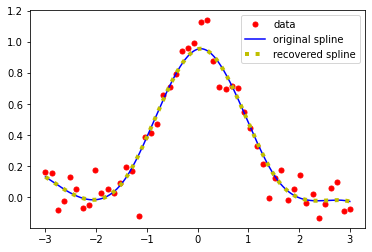

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline

x = np.linspace(-3, 3, 50)
y = np.exp(-x**2) + 0.1 * np.random.randn(50)

spl1 = UnivariateSpline(x, y, s=.5)
xi = np.linspace(-3, 3, 1000)

tck = spl1._eval_args
spl2 = UnivariateSpline._from_tck(tck)

plt.plot(x, y, 'ro', ms=5, label='data')
plt.plot(xi, spl1(xi), 'b', label='original spline')
plt.plot(xi, spl2(xi), 'y:', lw=4, label='recovered spline')

plt.legend()
plt.show()